In [ ]:
import numpy as np
from scipy.stats import sem
from os.path import expanduser
import scipy.io
import os.path
import pyret

# import my functions
#import info_theory_functions as info
#from lnl_model_functions import *
#from atick_redlich_functions import *
#from get_davids_data import *
#from image_processing_functions import *


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

import mpld3

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load stim and spikes

In [48]:
stim_dir = expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/high contrast - low contrast/2009_0818/stimulus')
spikes_dir = expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/high contrast - low contrast/2009_0818/spikes')

stim = scipy.io.loadmat(stim_dir + '/stim.mat', squeeze_me=True)
spikes = []
for i in xrange(25):
    filename = 'c%s_0.txt' %(str(i))
    full_path = spikes_dir + '/' + filename
    if os.path.isfile(full_path):
        this_cell = np.loadtxt(full_path, skiprows=1)
        spikes.append(this_cell)

# Create time vector for stimulus

In [49]:
stim['A1'].shape

(96, 450, 53)

In [50]:
stim['T1'].shape

(96, 450)

In [84]:
frame_rate = 0.033346 # from Igor Pro, "print FT" in *_types.pxp
stim_time = linspace(0, 
                     frame_rate*stim['T1'].shape[1] + frame_rate*np.prod(stim['A1'].shape[1:]) + frame_rate*np.prod(stim['P1'].shape[1:]), 
                     stim['T1'].shape[1] + np.prod(stim['A1'].shape[1:]) + np.prod(stim['P1'].shape[1:]))

In [85]:
np.max(stim_time)

1605.6098999999999

In [53]:
num_trials = stim['A1'].shape[2]
duration_per_trial = stim['A1'].shape[1] * frame_rate

In [54]:
duration_per_trial

15.005700000000001

# Create stimulus

In [93]:
stimulus = np.zeros((stim['A1'].shape[0], len(stim_time)))

In [109]:
frames_per_trial = stim['A1'].shape[1]
for t in xrange(1+2*num_trials):
    if t == 0:
        # first high_contrast
        stimulus[:,:frames_per_trial] = stim['T1']
    elif t % 2 == 0:
        # high contrast
        stimulus[:,t*frames_per_trial:(t+1)*frames_per_trial] = stim['A1'][:,:,int(floor(t/2. - 1))]
    elif t % 2 == 1:
        # low contrast
        stimulus[:,t*frames_per_trial:(t+1)*frames_per_trial] = stim['P1'][:,:,int(floor(t/2.))]

# Separate high and low contrast spikes

In [169]:
cell = 10
low_contrast  = []
high_contrast = []
for t in xrange(1+2*num_trials):
    time_interval = [t*duration_per_trial, (t+1)*duration_per_trial]
    # sequence is high, low, high, low, ...
    if t % 2 == 0:
        high_contrast.append(spikes[cell][(spikes[cell] > time_interval[0]) & (spikes[cell] <= time_interval[1])])
    else:
        low_contrast.append(spikes[cell][(spikes[cell] > time_interval[0]) & (spikes[cell] <= time_interval[1])])

In [170]:
def get_sta(stimulus, stim_time, spikes):
    # make STA 400 ms long
    sta_length = int(floor(.4/frame_rate))
    sta = np.zeros((stimulus.shape[0], sta_length))
    for sp in spikes:
        ind = np.argmin(abs(sp - stim_time[stim_time < sp]))
        sta += stimulus[:,ind-sta_length:ind]
    return sta/len(spikes)

In [171]:
sta_low  = get_sta(stimulus, stim_time, [item for sublist in low_contrast for item in sublist])
sta_high = get_sta(stimulus, stim_time, [item for sublist in high_contrast for item in sublist])

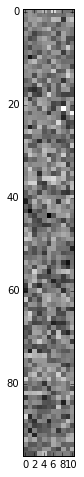

In [172]:
imshow(sta_high)